### interface:

### 加载数据 按照文件夹load 或者 给出文件列表
FCT(self, loads, algs, filelist, normalize_lists) or 
FCT(self, folder, toponame, flownum, loads, algs, normalize_lists)

### flow_size小于limit的FCT_load图
plot_FCT_load(self, algs, loads, flow_lim)
### 给出固定load，固定percentile FCT_load图
plot_FCT_percentile_fix_load(self, algs, load, percentile, flow_size)
### 所有流 Mean FCT_load图
plotting_mean_FCT(self)
### FCT点图
plot_FCT_flowsize(self, alg, load, color=None, label=None)
### 各组平均 FCT 按flow_size分组
plot_Mean_FCT_fix_load(self, algs, load, flow_size)

In [127]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
import math
from IPython.display import display, HTML
from scipy.interpolate import interp1d


In [259]:
# result-CDF_1333.tcl.txt
def loadNormalizeList(directory, flow_size):
    #offset = len("AFQ10UlimPL ")
    offset = 14 - 1   # Peixuan
    result = []
    for size in flow_size:
        #with open(directory + 'result-CDF_' + str(size) + '.tcl.txt', 'r') as f:
        with open(directory + 'tcp_AFQ10UlimPL_Topology-4hosts-4pods-random-fix.tcl_CDF_' + str(size) + '.tcl.tr', 'r') as f:
            #line = f.read()
            line_raw = f.read()    #Peixuan
            line = line_raw.split()
            #print(line[offset])
            #result.append(float(line[offset:]))
            result.append(float(line[offset]))
    return [flow_size, result]

class FCT:

    def __init__(self,*args):
        if (len(args) == 6):
            self.loadFromFloder(args[0], args[1], args[2], args[3], args[4], args[5])
        elif (len(args) == 4):
            self.loadFromFileList(args[0], args[1], args[2], args[3])
        else:
            raise Exception('parameter number must be 6 or 4')
    
    def expandNormalizedList(self, normalize_lists):
        interpolate_function = interp1d(normalize_lists[0], normalize_lists[1], kind='linear')
        max_value = max(normalize_lists[0])
        min_value = min(normalize_lists[0])
        xint = np.linspace(min_value, max_value, max_value - min_value + 1)
        return interpolate_function(xint)
        
    def loadFromFileList(self, loads, algs, filelist, normalize_lists):
        if (len(loads) * len(algs) != len(filelist)):
            raise Exception('the filelist is not match with loads and algs')
        self.loads = loads
        self.algs = algs
        self.raw_data = [[0 for i in range(len(loads))] for i in range(len(algs))]
        if len(normalize_lists) != 2 or len(normalize_lists[0]) != len(normalize_lists[1]):
            raise Exception('normalize_lists shoule contains two list with same length')
        normalizor = self.expandNormalizedList(normalize_lists)
        index=0
        for alg_i in range(len(algs)):
            for load_i in range(len(loads)):
                self.raw_data[alg_i][load_i] = self.parse_trace("", filelist[index], normalizor)
                index+=1
                        
    def loadFromFloder(self, folder, toponame, flownum, loads, algs, normalize_lists):
        self.loads = loads
        self.algs = algs
        self.raw_data = [[0 for i in range(len(loads))] for i in range(len(algs))]
        normalizor = self.expandNormalizedList(normalize_lists)
        for alg_i in range(len(algs)):
            for load_i in range(len(loads)):
                alg = algs[alg_i]
                load = loads[load_i]
                # print("tcp_"+alg+"_flow_"+str(flownum)+"_"+str(load)+"_"+toponame+".tr")
                self.raw_data[alg_i][load_i] = \
                    self.parse_trace(folder, \
                                     alg+"/tcp_flow_"+str(flownum)+"_"+str(load)+"_"+toponame+".tr", \
                                     normalizor)
    
    # At least two
    def plotting_mean_FCT(self):
        self.plot_FCT_load(self.algs, self.loads, float('inf'))
    
    # Normalized FCT = Actual FCT / min FCT
    # min FCT = flow_size / max bandwidth
    def parse_trace(self, directory, filename, normalizor):
        col = ["tmp_pkts", "flow duration", "fin_fid", "rtt times", \
                   "group_id", "Tw_", "Tp_", "Np_", "?1", "?2", "?3", "?4", "?5", "Average rate", "start time"]
        df = pd.read_csv(directory + filename, sep = ' ', header = None)
        df.columns = col
        df["Normalized FCT"] = df["tmp_pkts"].apply(lambda x: normalizor[int(x)]) / df["Average rate"]
        return df
    
    def get_load_id(self, load):
        return self.loads.index(load)
    
    def get_alg_id(self, alg):
        return self.algs.index(alg)
    
    def humanbytes(self, B):
        B = float(B)
        KB = float(1000)
        MB = float(KB ** 2)
        GB = float(KB ** 3)
        TB = float(KB ** 4) 

        if B < KB:
            return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
        elif KB <= B < MB:
            return '{0:.2f} KB'.format(B/KB)
        elif MB <= B < GB:
            return '{0:.2f} MB'.format(B/MB)
        elif GB <= B < TB:
            return '{0:.2f} GB'.format(B/GB)
        elif TB <= B:
            return '{0:.2f} TB'.format(B/TB)
        
    def plot_FCT_flowsize(self, alg, load, color=None, label=None):
        alg_id=self.get_alg_id(alg)
        load_id=self.get_load_id(load)
        df=self.raw_data[alg_id][load_id]
        y = df['Normalized FCT']
        x = df['tmp_pkts']
        plt.yscale('log')
        plt.scatter(x, y, color=color, label=label)
        plt.xlabel('flow size')
        plt.ylabel('Normalized FCT')
        #plt.legend()
        plt.show()
    
    ## internal
    def plot_one_FCT_percentile(self, alg, load, percentile, flow_size, isLast=False):
        alg_id=self.get_alg_id(alg)
        load_id=self.get_load_id(load)
        df = self.raw_data[alg_id][load_id]
        # cut -> (,]
        cate=pd.cut(df["tmp_pkts"], flow_size, labels=flow_size[:-1])
        selected_flow=[]
        corresponding_flow_size=[]
        for label in flow_size[:-1]:
            seg_data=df[cate == label]
            res=seg_data.sort_values(by=['Normalized FCT'])
            res.reset_index(inplace=True)
            if res.shape[0] == 0:
                continue
            # 16 indicate col 'Normalized FCT' 
            # print(res.iloc[[math.ceil((res.shape[0]-1) * 0.95)]])
            selected_flow.append(res.iloc[math.ceil((res.shape[0]-1) * percentile), 16])
            corresponding_flow_size.append(label)
        len_range=[i for i in range(len(corresponding_flow_size))]
        plt.plot(len_range, selected_flow, label=alg)
        plt.yscale('log')
        if (isLast):
            plt.xlabel('flow size')
            plt.ylabel('Normalized FCT')
            plt.title("load:"+str(load)+" percentile:"+str(percentile))
            plt.grid()
            #plt.legend()
            #plt.yticks([0,50,100,150,200])
            plt.xticks(len_range, [self.humanbytes(i*1500) for i in corresponding_flow_size])
            plt.show()

    ## internal
    def plot_one_FCT_mean(self, alg, load, flow_size, isLast=False):
        alg_id=self.get_alg_id(alg)
        load_id=self.get_load_id(load)
        df = self.raw_data[alg_id][load_id]
        # cut -> (,]
        cate=pd.cut(df["tmp_pkts"], flow_size, labels=flow_size[:-1])
        selected_flow=[]
        corresponding_flow_size=[]
        for label in flow_size[:-1]:
            seg_data=df[cate == label]
            res=seg_data.sort_values(by=['Normalized FCT'])
            res.reset_index(inplace=True)
            if res.shape[0] == 0:
                continue
            # 16 indicate col 'Normalized FCT' 
            selected_flow.append(res.iloc[:, 16].mean())
            corresponding_flow_size.append(label)
        len_range=[i for i in range(len(corresponding_flow_size))]
        plt.plot(len_range, selected_flow, label=alg)
        plt.yscale('log')
        if (isLast):
            plt.xlabel('flow size')
            plt.ylabel('Normalized FCT')
            plt.title("load:"+str(load)+" mean")
            plt.grid()
            #plt.legend()
            plt.xticks(len_range, [self.humanbytes(i*1500) for i in corresponding_flow_size])
            plt.show()
    
    #plot FCT of a sepecific percentile divided by flow_size
    def plot_FCT_percentile_fix_load(self, algs, load, percentile, flow_size):
        fig= plt.figure(figsize=(18,3))
        for alg in algs:
            if alg == algs[-1]:
                self.plot_one_FCT_percentile(alg, load, percentile, flow_size, True)
            else:
                self.plot_one_FCT_percentile(alg, load, percentile, flow_size, False)
                
    #plot FCT of a sepecific percentile divided by flow_size Prixuan 0628
    def plot_FCT_percentile_fix_load_mark(self, algs, load, percentile, flow_size):
        fig= plt.figure(figsize=(8,5))
        for alg in algs:
            if alg == algs[-1]:
                self.plot_one_FCT_percentile_mark(alg, load, percentile, flow_size, True)
            else:
                self.plot_one_FCT_percentile_mark(alg, load, percentile, flow_size, False)
                
    ## internal
    def plot_one_FCT_percentile_mark(self, alg, load, percentile, flow_size, isLast=False):
        alg_id=self.get_alg_id(alg)
        load_id=self.get_load_id(load)
        df = self.raw_data[alg_id][load_id]
        # cut -> (,]
        cate=pd.cut(df["tmp_pkts"], flow_size, labels=flow_size[:-1])
        selected_flow=[]
        corresponding_flow_size=[]
        for label in flow_size[:-1]:
            seg_data=df[cate == label]
            res=seg_data.sort_values(by=['Normalized FCT'])
            res.reset_index(inplace=True)
            if res.shape[0] == 0:
                continue
            # 16 indicate col 'Normalized FCT' 
            # print(res.iloc[[math.ceil((res.shape[0]-1) * 0.95)]])
            selected_flow.append(res.iloc[math.ceil((res.shape[0]-1) * percentile), 16])
            corresponding_flow_size.append(label)
        len_range=[i for i in range(len(corresponding_flow_size))]
        plt.plot(len_range, selected_flow, label=alg, lw = 3)
        plt.yscale('log')
        if (isLast):
            #plt.title("load:"+str(load)+" percentile:"+str(percentile))
            plt.xlabel('flow size', fontsize = 16)
            plt.ylabel('Normalized FCT', fontsize = 16)
            plt.tick_params(labelsize = 16)
            #plt.title("load:"+str(load)+" mean", fontsize = 16)
            plt.grid()
            #plt.legend(fontsize = 12)
            plt.xticks(len_range, [self.humanbytes(i*1500) for i in corresponding_flow_size], rotation=45, fontsize = 16)
            #for tick in ax1.get_xticklabels():
            #    tick.set_rotation(60)
            #pl.xticks(rotation=60)
            plt.ylim(top=200)
            plt.show()



    #plot Mean FCT divided by flow_size
    def plot_Mean_FCT_fix_load(self, algs, load, flow_size):
        fig= plt.figure(figsize=(18,3))
        for alg in algs:
            if alg == algs[-1]:
                self.plot_one_FCT_mean(alg, load, flow_size, True)
            else:
                self.plot_one_FCT_mean(alg, load, flow_size, False)
                
    # internal
    def plot_one_FCT_load(self, alg, loads, flow_lim, isLast=False):
        alg_id=self.get_alg_id(alg)
        df = self.raw_data[alg_id][:]
        y = []
        for load in loads:
            load_id=self.get_load_id(load)
            df_one = df[load_id]
            y.append(df_one[df_one['tmp_pkts']<flow_lim]['Normalized FCT'].mean())
        plt.yscale('log')
        plt.plot(loads, y, label=alg)
        if (isLast):
            plt.xlabel('load')
            plt.ylabel('Normalized FCT')
            plt.grid()
            #plt.legend()
            plt.show()
    
    # plot FCT_load graph
    # the mean of all the flows of flow size under flow_lim
    def plot_FCT_load(self, algs, loads, flow_lim):
        fig= plt.figure(figsize=(18,3))
        for alg in algs:
            if alg == algs[-1]:
                self.plot_one_FCT_load(alg, loads, flow_lim, True)
            else:
                self.plot_one_FCT_load(alg, loads, flow_lim, False)       

                
    #Peixuan: plot with mark
    
    ## internal
    def plot_one_FCT_mean_mark(self, alg, load, flow_size, isLast=False):
        alg_id=self.get_alg_id(alg)
        load_id=self.get_load_id(load)
        df = self.raw_data[alg_id][load_id]
        # cut -> (,]
        cate=pd.cut(df["tmp_pkts"], flow_size, labels=flow_size[:-1])
        selected_flow=[]
        corresponding_flow_size=[]
        for label in flow_size[:-1]:
            seg_data=df[cate == label]
            res=seg_data.sort_values(by=['Normalized FCT'])
            res.reset_index(inplace=True)
            if res.shape[0] == 0:
                continue
            # 16 indicate col 'Normalized FCT' 
            selected_flow.append(res.iloc[:, 16].mean())
            corresponding_flow_size.append(label)
        len_range=[i for i in range(len(corresponding_flow_size))]
        plt.plot(len_range, selected_flow, label=alg, lw = 3)
        plt.yscale('log')
        if (isLast):
            plt.xlabel('flow size', fontsize = 16)
            plt.ylabel('FCT Slowdown', fontsize = 16)
            plt.tick_params(labelsize = 16)
            #plt.title("load:"+str(load)+" mean", fontsize = 16)
            plt.grid()
            plt.legend(fontsize = 12)
            plt.xticks(len_range, [self.humanbytes(i*1500) for i in corresponding_flow_size], rotation=45, fontsize = 16)
            #for tick in ax1.get_xticklabels():
            #    tick.set_rotation(60)
            #pl.xticks(rotation=60)
            plt.ylim(top=20)
            plt.show()
    
    #Peixuan: plot Mean FCT divided by flow_size
    def plot_Mean_FCT_fix_load_mark(self, algs, load, flow_size):
        fig= plt.figure(figsize=(8,5))
        for alg in algs:
            if alg == algs[-1]:
                self.plot_one_FCT_mean_mark(alg, load, flow_size, True)
            else:
                self.plot_one_FCT_mean_mark(alg, load, flow_size, False)

                
                
                
    # At least two
    def plotting_mean_FCT_mark(self):
        self.plot_FCT_load_mark(self.algs, self.loads, float('inf'))
        
    # At least two Peixuan 0628
    def plotting_pct_FCT_mark(self, pct):
        self.plot_FCT_load_pct_mark(self.algs, self.loads, pct, float('inf'))
    
    # plot FCT_load graph
    # the mean of all the flows of flow size under flow_lim
    def plot_FCT_load_mark(self, algs, loads, flow_lim):
        fig= plt.figure(figsize=(8,5))
        for alg in algs:
            if alg == algs[-1]:
                self.plot_one_FCT_load_mark(alg, loads, flow_lim, True)
            else:
                self.plot_one_FCT_load_mark(alg, loads, flow_lim, False)
    # internal
    def plot_one_FCT_load_mark(self, alg, loads, flow_lim, isLast=False):
        alg_id=self.get_alg_id(alg)
        df = self.raw_data[alg_id][:]
        y = []
        for load in loads:
            load_id=self.get_load_id(load)
            df_one = df[load_id]
            y.append(df_one[df_one['tmp_pkts']<flow_lim]['Normalized FCT'].mean())
        plt.yscale('log', fontsize = 16)
        plt.plot(loads, y, label=alg, lw=2, marker = "o", markersize = 10,)
        if (isLast):
            plt.xlabel('load', fontsize = 16)
            plt.ylabel('Average FCT slowdown', fontsize = 16)
            plt.tick_params(labelsize = 16)
            plt.xticks(fontsize = 16)
            plt.yticks(fontsize = 16)
            plt.legend(fontsize = 12)
            plt.grid()
            #plt.legend()
            plt.show()
            
    # plot FCT_load graph
    # the pct of all the flows of flow size under flow_lim
    def plot_FCT_load_pct_mark(self, algs, loads, pct, flow_lim):
        fig= plt.figure(figsize=(8,5))
        for alg in algs:
            if alg == algs[-1]:
                self.plot_one_FCT_load_pct_mark(alg, loads, pct, flow_lim, True)
            else:
                self.plot_one_FCT_load_pct_mark(alg, loads, pct, flow_lim, False)
    # internal
    def plot_one_FCT_load_pct_mark(self, alg, loads, pct, flow_lim, isLast=False):
        alg_id=self.get_alg_id(alg)
        df = self.raw_data[alg_id][:]
        y = []
        for load in loads:
            load_id=self.get_load_id(load)
            df_one = df[load_id]
            #y.append(df_one[df_one['tmp_pkts']<flow_lim]['Normalized FCT'].mean())
            y.append(df_one[df_one['tmp_pkts']<flow_lim]['Normalized FCT'].quantile(pct))
        plt.yscale('log', fontsize = 16)
        plt.plot(loads, y, label=alg, lw=2, marker = "o", markersize = 10)
        if (isLast):
            plt.xlabel('load', fontsize = 16)
            plt.ylabel('99th percentile FCT slowdown', fontsize = 16)
            plt.tick_params(labelsize = 16)
            plt.xticks(fontsize = 16)
            plt.yticks(fontsize = 16)
            plt.legend(fontsize = 10)
            plt.grid()
            #plt.legend()
            plt.show()

In [260]:
#import pylab as pl

#pl.xticks(rotation=360)

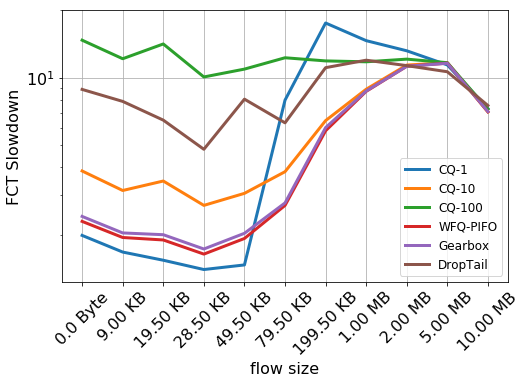

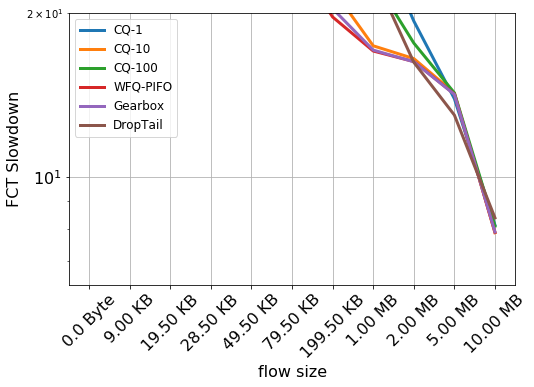

In [261]:
if __name__ == '__main__':
    FCT_analysis_normalize.plot_Mean_FCT_fix_load_mark(
        alg_list, 0.9, flow_size)

    FCT_analysis_original.plot_Mean_FCT_fix_load_mark(
        alg_list, 0.9, flow_size)

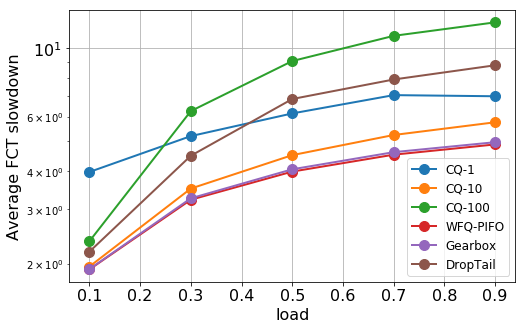

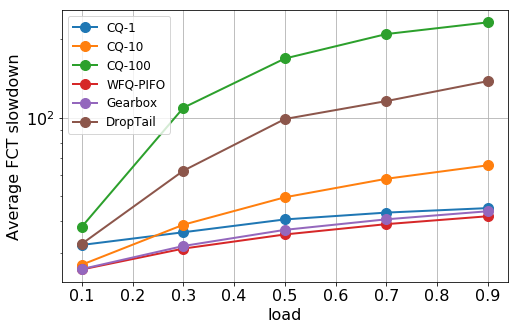

In [262]:
if __name__ == '__main__':
    FCT_analysis_normalize.plotting_mean_FCT_mark()
    FCT_analysis_original.plotting_mean_FCT_mark()

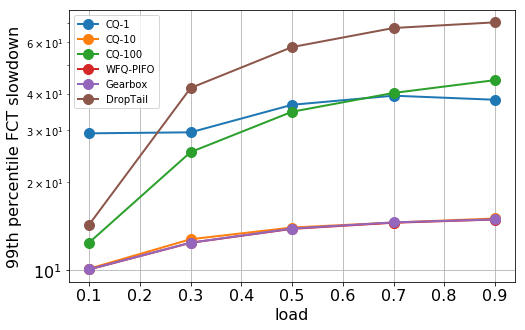

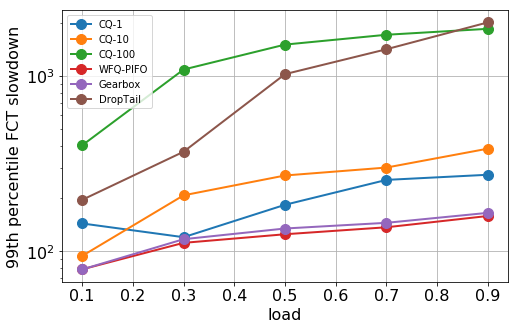

In [277]:
if __name__ == '__main__':
    FCT_analysis_normalize.plotting_pct_FCT_mark(0.99)
    FCT_analysis_original.plotting_pct_FCT_mark(0.99)

### Initialization

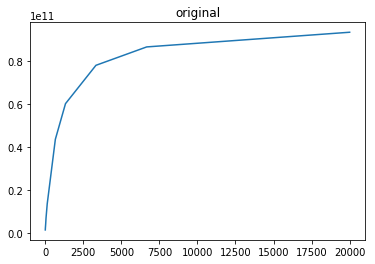

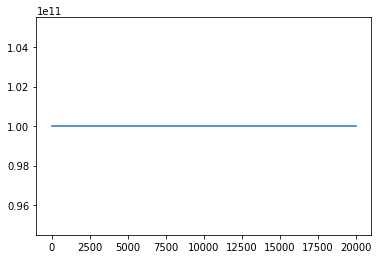

In [264]:
if __name__ == '__main__':
    flow_size=[0, 6, 13, 19, 33, 53, 133, 667, 1333, 3333, 6667, 20000, float('inf')]
    #normalize_lists = loadNormalizeList('/Users/peixuangao/Desktop/flowBenchmark/', flow_size[1:-1])
    normalize_lists = loadNormalizeList('/Users/peixuangao/Documents/NYU/Project/NS2/Hyline/Gearbox-Hyline/data/portland/tcp_random_pair_32host/diff_host_4pods/Flow_benchmark/', flow_size[1:-1])
    plt.plot(normalize_lists[0], normalize_lists[1])
    plt.title("original")
    plt.show()
    
    original_lists=[flow_size[1:-1],[100 * 1e9 for i in range(len(flow_size) - 2)]]
    plt.plot(original_lists[0], original_lists[1])
    

In [265]:


#folder = "/Users/peixuangao/Documents/NYU/Project/NS2/Hyline/Gearbox-Hyline/data/portland/singlenode/ori_32hostsPerSw/"
#folder = "/Users/peixuangao/Documents/NYU/Project/NS2/Hyline/Gearbox-Hyline/data/portland/tcp_random_pair_32host/NSDI20_10_40/FID/"
#folder = "/Users/peixuangao/Documents/NYU/Project/NS2/Hyline/Gearbox-Hyline/data/portland/tcp_bw_incast_single_node/Ori/ori_2hostsPerSw_10Gx10G/"
#folder = "/Users/peixuangao/Documents/NYU/Project/NS2/Hyline/Gearbox-Hyline/data/portland/tcp_random_pair_32host/4pods/FID/"
#folder = "/Users/peixuangao/Documents/NYU/Project/NS2/Hyline/Gearbox-Hyline/data/portland/tcp_random_pair_32host/4pods/HSNL103/FID/"
#folder = "/Users/peixuangao/Documents/NYU/Project/NS2/Hyline/Gearbox-Hyline/data/portland/tcp_random_pair_32host/diff_host_4pods/4host_FID/"
folder = "/Users/peixuangao/Documents/NYU/Project/NS2/Hyline/Gearbox-Hyline/data/portland/tcp_random_pair_32host/diff_host_4pods/4host/"

In [266]:
topo = "Topology-4hosts-4pods-random.tcl"
flow_num = 1000
flow_num_str = "1000"

In [267]:
"""if __name__ == '__main__':
    folder = "/home/ovs2/lining/Gearbox/automatic/"
    FCT_analysis = FCT(
        [.5], \
        ["AFQ10UlimPL"],\
        [
            folder + "tcp_AFQ10UlimPL_flow_100_0.5_Topology-incast-singlenode.tcl.tr"
        ],\
        normalize_lists)"""

if __name__ == '__main__':
    #folder = "/Users/peixuangao/Documents/NYU/Project/NS2/Hyline/Gearbox-Hyline/data/portland/singlenode/ori_2hostsPerSw/"
    FCT_analysis = FCT(
        [.5], \
        ["AFQ10UlimPL"],\
        [
            #folder + "tcp-incast-AFQ10unlim/" + "tcp_flow_500_0.5_Topology-incast-singlenode.tcl.tr"
            #folder + "tcp-incast-AFQ10unlim/" + "tcp_flow_500_0.5_Topology-32hosts.tcl.tr"
            #folder + "tcp-incast-AFQ10unlim/" + "tcp_flow_500_0.5_Topology-32hosts-NSDI20.tcl.tr"
            #folder + "tcp-incast-AFQ10unlim/" + "tcp_flow_500_0.5_Topology-bw-incast-singlenode.tcl.tr"
            #folder + "tcp-incast-AFQ10unlim/" + "tcp_flow_1000_0.5_Topology-32hosts.tcl.tr"
            #folder + "tcp-incast-AFQ10unlim/" + "tcp_flow_1000_0.5_Topology-4pods-random.tcl.tr"
            #folder + "tcp-incast-AFQ10unlim/" + "tcp_flow_"+flow_num_str+"_0.5_"+topo+".tr"
            folder + "WFQ-PIFO/" + "tcp_flow_"+flow_num_str+"_0.5_"+topo+".tr"

        ],\
        normalize_lists)

In [268]:
# ignored
"""if __name__ == '__main__':
    # using some file
    folder = "/home/ovs2/lining/Gearbox/automatic/"
    FCT_analysis = FCT(
        [.1, 0.2, 0.3], \
        ["DropTail", "AFQ10PL"],\
        [
            folder + "tcp_DropTail_flow_100_0.1_Topology-incast-singlenode.tcl.tr",\
            folder + "tcp_DropTail_flow_100_0.2_Topology-incast-singlenode.tcl.tr",\
            folder + "tcp_DropTail_flow_100_0.3_Topology-incast-singlenode.tcl.tr",\
            folder + "tcp_AFQ10PL_flow_100_0.1_Topology-incast-singlenode.tcl.tr",\
            folder + "tcp_AFQ10PL_flow_100_0.2_Topology-incast-singlenode.tcl.tr",\
            folder + "tcp_AFQ10PL_flow_100_0.3_Topology-incast-singlenode.tcl.tr"\
        ],\
        normalize_lists)"""

'if __name__ == \'__main__\':\n    # using some file\n    folder = "/home/ovs2/lining/Gearbox/automatic/"\n    FCT_analysis = FCT(\n        [.1, 0.2, 0.3],         ["DropTail", "AFQ10PL"],        [\n            folder + "tcp_DropTail_flow_100_0.1_Topology-incast-singlenode.tcl.tr",            folder + "tcp_DropTail_flow_100_0.2_Topology-incast-singlenode.tcl.tr",            folder + "tcp_DropTail_flow_100_0.3_Topology-incast-singlenode.tcl.tr",            folder + "tcp_AFQ10PL_flow_100_0.1_Topology-incast-singlenode.tcl.tr",            folder + "tcp_AFQ10PL_flow_100_0.2_Topology-incast-singlenode.tcl.tr",            folder + "tcp_AFQ10PL_flow_100_0.3_Topology-incast-singlenode.tcl.tr"        ],        normalize_lists)'

In [269]:
"""if __name__ == '__main__':
    # automatic folder All
    FCT_analysis_normalize = FCT("/home/ovs2/lining/Gearbox/automatic/", \
                       "Topology-incast-singlenode.tcl",\
                       100, \
                       [.1, .2, .3, .4, .5, .6, .7, .8, .9, .95], \
                       ["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"],\
                       normalize_lists)
    FCT_analysis_original = FCT("/home/ovs2/lining/Gearbox/automatic/", \
                       "Topology-incast-singlenode.tcl",\
                       100, \
                       [.1, .2, .3, .4, .5, .6, .7, .8, .9, .95], \
                       ["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"],\
                       original_lists)"""

#alg_list = ["tcp-incast-AFQ10", "tcp-incast-AFQ100", "tcp-incast-AFQ1000", "tcp-incast-AFQ10unlim", "tcp-incast-HRCC", "tcp-incast-DropTail"]

#alg_list = ["tcp-incast-AFQ10", "tcp-incast-AFQ100", "tcp-incast-AFQ1000", "tcp-incast-AFQ10unlim", "tcp-incast-HRCC"]

#alg_list = ["tcp-incast-AFQ10", "tcp-incast-AFQ100", "tcp-incast-AFQ1000", "tcp-incast-AFQ10unlim", "tcp-incast-HRCC", "tcp-incast-DropTail", "tcp-incast-LargeDropTail", "tcp-incast-BDPDropTail"]

alg_list = ["CQ-1", "CQ-10", "CQ-100", "WFQ-PIFO", "Gearbox", "DropTail"]


if __name__ == '__main__':
    # automatic folder All
    FCT_analysis_normalize = FCT(folder, \
                       #"Topology-incast-singlenode.tcl",\
                       #"Topology-32hosts.tcl",\
                       #"Topology-32hosts-NSDI20.tcl",\
                       #"Topology-bw-incast-singlenode.tcl",\
                       #"Topology-4pods-random.tcl",\
                       topo,\
                       #500, \
                       #1000, \
                       flow_num,\
                       [.1, .3, .5, .7, .9,], \
                       #["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"],\
                       alg_list,\
                       normalize_lists)
    FCT_analysis_original = FCT(folder, \
                       #"Topology-incast-singlenode.tcl",\
                       #"Topology-32hosts.tcl",\
                       #"Topology-32hosts-NSDI20.tcl",\
                       #"Topology-bw-incast-singlenode.tcl",\
                       #"Topology-4pods-random.tcl",\
                       topo,\
                       #500, \
                       #1000, \
                       flow_num,\
                       [.1, .3, .5, .7, .9,], \
                       #["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"],\
                       alg_list,\
                       original_lists)

In [270]:
#original_lists

### plot_FCT_percentile_fix_load(self, algs, load, percentile, flow_size)

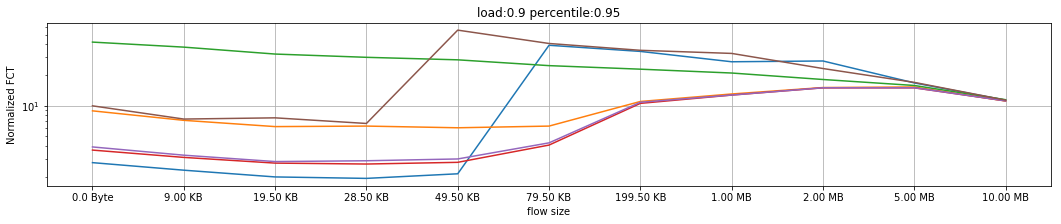

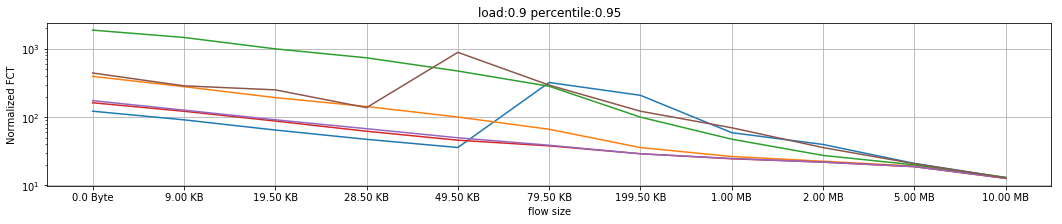

In [271]:
alg_list = ["CQ-1", "CQ-10", "CQ-100", "WFQ-PIFO", "Gearbox", "DropTail"]

#alg_list = ["tcp-incast-AFQ10", "tcp-incast-AFQ100", "tcp-incast-AFQ1000", "tcp-incast-AFQ10unlim", "tcp-incast-HRCC", "tcp-incast-DropTail"]

#alg_list = ["tcp-incast-AFQ10", "tcp-incast-AFQ100", "tcp-incast-AFQ1000", "tcp-incast-AFQ10unlim", "tcp-incast-HRCC"]

#alg_list = ["tcp-incast-AFQ10", "tcp-incast-AFQ100", "tcp-incast-AFQ1000", "tcp-incast-AFQ10unlim", "tcp-incast-HRCC", "tcp-incast-DropTail", "tcp-incast-LargeDropTail", "tcp-incast-BDPDropTail"]

if __name__ == '__main__':
    flow_size=[0, 6, 13, 19, 33, 53, 133, 667, 1333, 3333, 6667, float('inf')]
    FCT_analysis_normalize.plot_FCT_percentile_fix_load(\
                    #["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"],\
                    alg_list,\
                    .9,\
                    .95,\
                    flow_size)
    FCT_analysis_original.plot_FCT_percentile_fix_load(\
                    #["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"],\
                    alg_list,\
                    .9,\
                    .95,\
                    flow_size)


### plot_FCT_load(self, algs, loads, flow_lim)

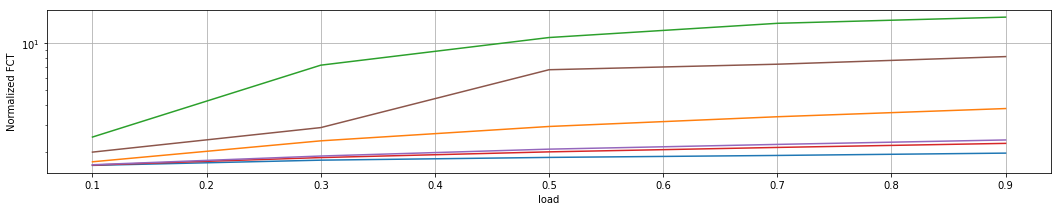

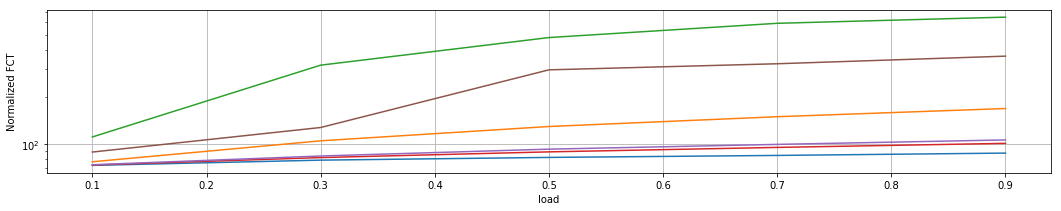

In [272]:
"""if __name__ == '__main__':
    FCT_analysis_normalize.plot_FCT_load(["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"], \
                                     [.4, .5, .6, .7, .8, .9, .95], 10)
    FCT_analysis_original.plot_FCT_load(["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"], \
                                     [.4, .5, .6, .7, .8, .9, .95], 10)"""

if __name__ == '__main__':
    FCT_analysis_normalize.plot_FCT_load(alg_list, \
                                     [.1, .3, .5, .7, .9,], 10)
    FCT_analysis_original.plot_FCT_load(alg_list, \
                                     [.1, .3, .5, .7, .9,], 10)

### plotting_mean_FCT(self)

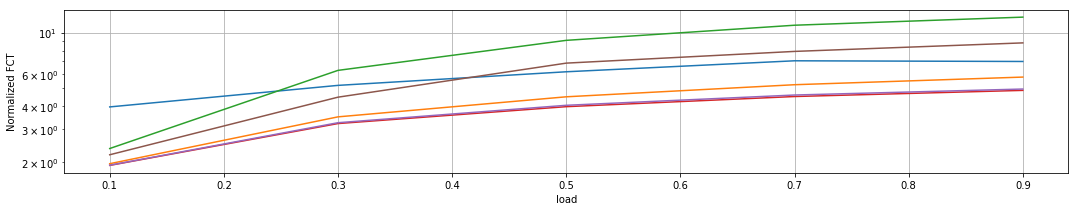

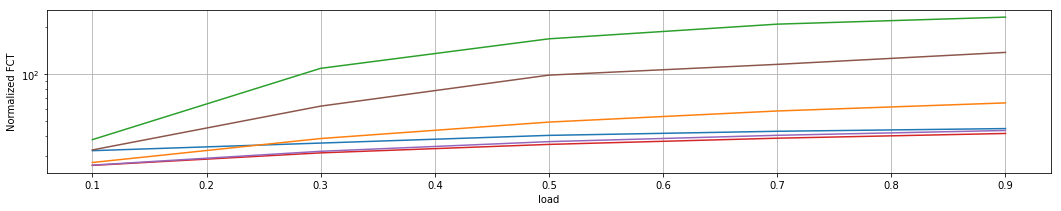

In [273]:
if __name__ == '__main__':
    FCT_analysis_normalize.plotting_mean_FCT()
    FCT_analysis_original.plotting_mean_FCT()

### plot_FCT_flowsize(self, alg, load, color=None, label=None)

In [274]:
"""if __name__ == '__main__':
    FCT_analysis_normalize.plot_FCT_flowsize("DropTail", .5, label = "DropTail 0.5", color = 'b')
    FCT_analysis_normalize.plot_FCT_flowsize("DropTail", .9, label = "DropTail 0.9", color = 'g')"""

if __name__ == '__main__':
    FCT_analysis_normalize.plot_FCT_flowsize("tcp-incast-DropTail", .5, label = "DropTail 0.5", color = 'b')
    FCT_analysis_normalize.plot_FCT_flowsize("tcp-incast-DropTail", .9, label = "DropTail 0.9", color = 'g')


ValueError: 'tcp-incast-DropTail' is not in list

### def plot_Mean_FCT_fix_load(self, algs, load, percentile, flow_size):

In [ ]:
"""if __name__ == '__main__':
    FCT_analysis_normalize.plot_Mean_FCT_fix_load(
        ["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"], 0.9, flow_size)

    FCT_analysis_original.plot_Mean_FCT_fix_load(
        ["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"], 0.9, flow_size)"""

if __name__ == '__main__':
    FCT_analysis_normalize.plot_Mean_FCT_fix_load(
        alg_list, 0.9, flow_size)

    FCT_analysis_original.plot_Mean_FCT_fix_load(
        alg_list, 0.9, flow_size)



In [ ]:
"""if __name__ == '__main__':
    FCT_analysis_normalize.plot_Mean_FCT_fix_load(
        ["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"], 0.9, flow_size)

    FCT_analysis_original.plot_Mean_FCT_fix_load(
        ["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"], 0.9, flow_size)"""

if __name__ == '__main__':
    FCT_analysis_normalize.plot_Mean_FCT_fix_load(
        alg_list, 0.7, flow_size)

    FCT_analysis_original.plot_Mean_FCT_fix_load(
        alg_list, 0.7, flow_size)

In [ ]:
"""if __name__ == '__main__':
    FCT_analysis_normalize.plot_Mean_FCT_fix_load(
        ["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"], 0.9, flow_size)

    FCT_analysis_original.plot_Mean_FCT_fix_load(
        ["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"], 0.9, flow_size)"""

if __name__ == '__main__':
    FCT_analysis_normalize.plot_Mean_FCT_fix_load(
        alg_list, 0.5, flow_size)

    FCT_analysis_original.plot_Mean_FCT_fix_load(
        alg_list, 0.5, flow_size)

In [ ]:
if __name__ == '__main__':
    FCT_analysis_normalize.plot_Mean_FCT_fix_load_mark(
        alg_list, 0.5, flow_size)

    FCT_analysis_original.plot_Mean_FCT_fix_load_mark(
        alg_list, 0.5, flow_size)

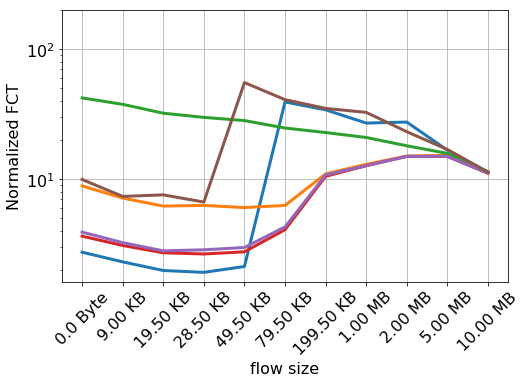

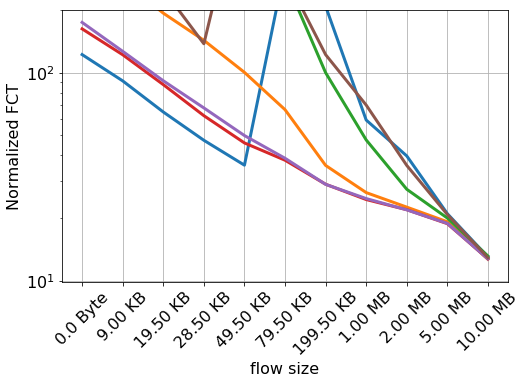

In [275]:
alg_list = ["CQ-1", "CQ-10", "CQ-100", "WFQ-PIFO", "Gearbox", "DropTail"]

if __name__ == '__main__':
    flow_size=[0, 6, 13, 19, 33, 53, 133, 667, 1333, 3333, 6667, float('inf')]
    FCT_analysis_normalize.plot_FCT_percentile_fix_load_mark(\
                    #["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"],\
                    alg_list,\
                    .9,\
                    .95,\
                    flow_size)
    FCT_analysis_original.plot_FCT_percentile_fix_load_mark(\
                    #["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"],\
                    alg_list,\
                    .9,\
                    .95,\
                    flow_size)

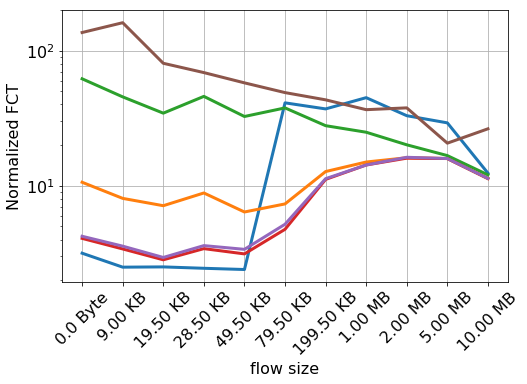

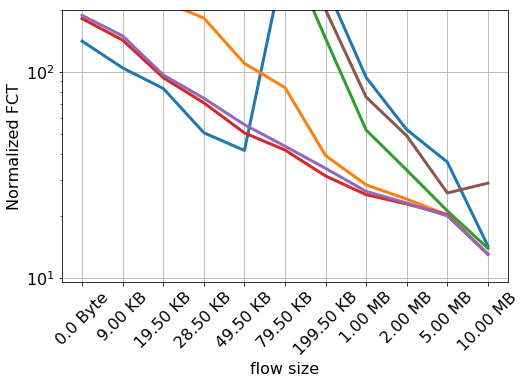

In [276]:
alg_list = ["CQ-1", "CQ-10", "CQ-100", "WFQ-PIFO", "Gearbox", "DropTail"]

if __name__ == '__main__':
    flow_size=[0, 6, 13, 19, 33, 53, 133, 667, 1333, 3333, 6667, float('inf')]
    FCT_analysis_normalize.plot_FCT_percentile_fix_load_mark(\
                    #["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"],\
                    alg_list,\
                    .9,\
                    .99,\
                    flow_size)
    FCT_analysis_original.plot_FCT_percentile_fix_load_mark(\
                    #["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"],\
                    alg_list,\
                    .9,\
                    .99,\
                    flow_size)

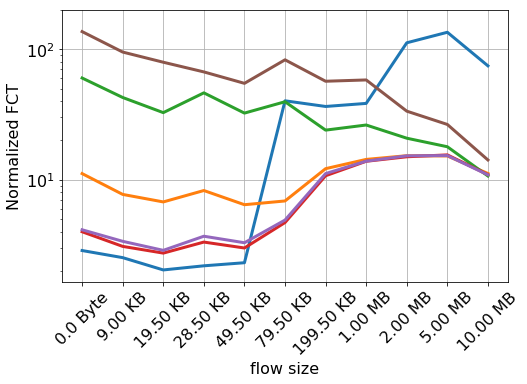

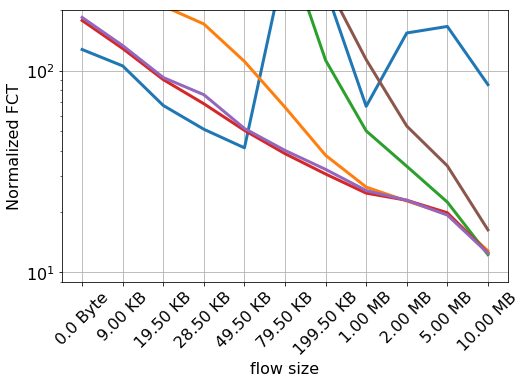

In [170]:
alg_list = ["CQ-1", "CQ-10", "CQ-100", "WFQ-PIFO", "Gearbox", "DropTail"]

if __name__ == '__main__':
    flow_size=[0, 6, 13, 19, 33, 53, 133, 667, 1333, 3333, 6667, float('inf')]
    FCT_analysis_normalize.plot_FCT_percentile_fix_load_mark(\
                    #["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"],\
                    alg_list,\
                    .7,\
                    .99,\
                    flow_size)
    FCT_analysis_original.plot_FCT_percentile_fix_load_mark(\
                    #["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"],\
                    alg_list,\
                    .7,\
                    .99,\
                    flow_size)

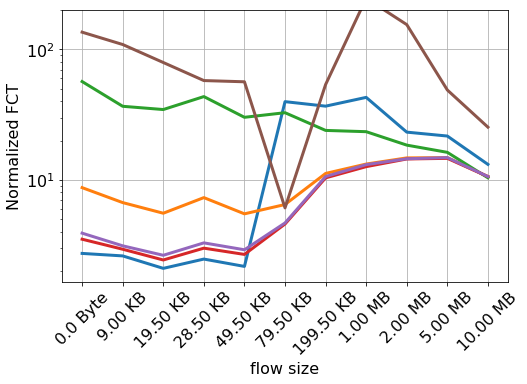

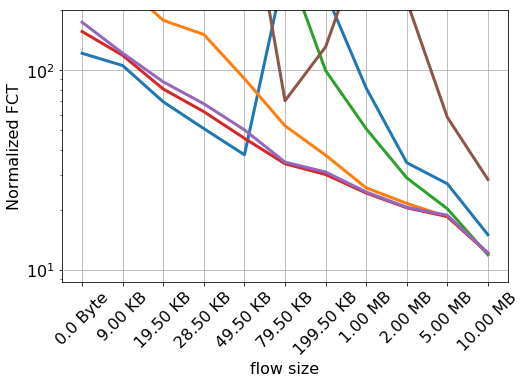

In [171]:
alg_list = ["CQ-1", "CQ-10", "CQ-100", "WFQ-PIFO", "Gearbox", "DropTail"]

if __name__ == '__main__':
    flow_size=[0, 6, 13, 19, 33, 53, 133, 667, 1333, 3333, 6667, float('inf')]
    FCT_analysis_normalize.plot_FCT_percentile_fix_load_mark(\
                    #["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"],\
                    alg_list,\
                    .5,\
                    .99,\
                    flow_size)
    FCT_analysis_original.plot_FCT_percentile_fix_load_mark(\
                    #["DropTail", "AFQ10UlimPL", "AFQ10PL", "AFQ100PL", "AFQ1000PL", "HRCCPL"],\
                    alg_list,\
                    .5,\
                    .99,\
                    flow_size)